<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label Image Detection of Fruits on a Platter

by Michael Hunziker

<br/>

My goal is to develop a deep learning model that can accurately identify and classify multiple fruits present in images of fruit platters.

The [dataset](https://universe.roboflow.com/suratthani-rajabhat-university/rcnn-oumhw) consists of images of fruit platters with various fruits arranged on them. Each image can contain one or more fruits from a set of 6 classes, including an "other" class for objects that are not among the defined fruit categories.

My approach applies theory I learned in the module "Computer Vision" by Susanne Suter and Marco Willi and tries to implement best practices according to [Karpathy:19](http://karpathy.github.io/2019/04/25/recipe/).

Google Colab GPUs: We start by using a A100 GPU

<br/>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base model from scratch

We start by creating a base model from scratch for predicting banana, no banana and a bounding box for the banana

### Loading the dataset

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/assignment-computer-vision
# !ls -l

/content/drive/MyDrive/assignment-computer-vision


In [4]:
%%capture

# %load_ext autoreload
# %autoreload 2
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import tensorflow as tf

# from sklearn.model_selection import train_test_split

class print_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [5]:
import plot_functions

In [6]:
!nvidia-smi
tf.config.list_physical_devices('GPU')

Fri Nov 29 19:19:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Dataset configuration
base_path = 'data'
num_classes = 2
input_size = 244

recreate_dataset = False # we load from drive

In [8]:
# Prepare for further processing
# Train
train_image_dir = os.path.join(base_path, 'train')
train_annotation_file = os.path.join(base_path, 'train/_annotations.csv')

if not os.path.exists(train_annotation_file):
    print(f"Error: Annotation file not found at {train_annotation_file}")

train_annotations = pd.read_csv(train_annotation_file)
train_image_files = glob.glob(os.path.join(train_image_dir, '*.jpg'))

# TEst
test_image_dir = os.path.join(base_path, 'test')
test_annotation_file = os.path.join(base_path, 'test/_annotations.csv')

if not os.path.exists(test_annotation_file):
    print(f"Error: Annotation file not found at {test_annotation_file}")

test_annotations = pd.read_csv(test_annotation_file)
test_image_files = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Validation
validation_image_dir = os.path.join(base_path, 'valid')
validation_annotation_file = os.path.join(base_path, 'valid/_annotations.csv')

if not os.path.exists(validation_annotation_file):
    print(f"Error: Annotation file not found at {validation_annotation_file}")

validation_annotations = pd.read_csv(validation_annotation_file)
validation_image_files = glob.glob(os.path.join(validation_image_dir, '*.jpg'))

We need a function to get all boxes for an image from the label file

In [9]:
# Get all boxes for an image

def get_boxes_for_image(filename, annotations):
    """
    Gets all boxes for a specific image from the annotations DataFrame.

    Args:
        filename: The name of the image file.
        annotations: The pandas DataFrame containing the annotations.

    Returns:
        A dictionary where keys are box indices and values are dictionaries
        containing 'xmin', 'ymin', 'xmax', 'ymax', and 'class' for each box.
        Returns an empty dictionary if no boxes are found for the image.
    """
    image_annotations = annotations[annotations['filename'] == filename]
    boxes_dict = {}
    for index, row in image_annotations.iterrows():
        boxes_dict[index] = {
            'box': row[['xmin', 'ymin', 'xmax', 'ymax']].values,
            'label': row['class']
        }
    return boxes_dict

And we need a function to display our images with the corresponding boxes

In [10]:
# A function for displaying an image with parameters image and boxes (each box has a label)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(plt_img, boxes):
    """Displays an image with bounding boxes and labels.

    Args:
        image_path: Path to the image file.
        boxes: A list of dictionaries, where each dictionary represents a box
               and contains 'xmin', 'ymin', 'xmax', 'ymax', and 'label' keys.
    """
    try:
        boxes = list(boxes.values())
        fig, ax = plt.subplots(1)
        ax.imshow(plt_img)

        for box in boxes:
            xmin = box['box'][0]
            ymin = box['box'][1]
            xmax = box['box'][2]
            ymax = box['box'][3]
            label = box['label']

            rect = patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the label to the box
            ax.text(xmin, ymin, label, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        plt.show()

    except KeyError as e:
        print(f"Error: Missing key in box dictionary: {e}")

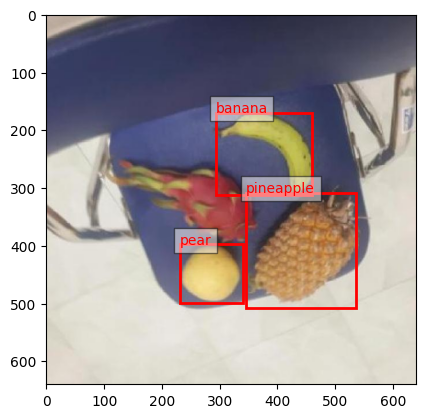

In [11]:
# Show an image from train_annotations using display_image_with_boxes

# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)
# print(first_boxes)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

We want to resize to a smaller size to test our small base model - it's important to resize the boxes too for this to work

In [12]:
import cv2 as cv
import numpy as np

def _resize_image_and_boxes(image, boxes, new_width, new_height):
    """Resizes the image and adjusts the bounding boxes accordingly."""
    # Get the original height and width using the 'shape' attribute
    original_height, original_width = image.shape[0], image.shape[1]

    # Resize using OpenCV
    resized_image = cv.resize(image, (new_width, new_height))

    # Adjust bounding boxes and maintain the original format
    resized_boxes = {}
    for box_index, box_data in boxes.items():
      # print(box_data['box'])
      xmin, ymin, xmax, ymax = box_data['box']
      xmin = int(xmin * new_width / original_width)
      ymin = int(ymin * new_height / original_height)
      xmax = int(xmax * new_width / original_width)
      ymax = int(ymax * new_height / original_height)

      # Ensure boxes stay within image bounds after resizing
      xmin = max(0, min(xmin, new_width - 1))
      ymin = max(0, min(ymin, new_height - 1))
      xmax = max(0, min(xmax, new_width - 1))
      ymax = max(0, min(ymax, new_height - 1))

      # Store the resized box in the same format as the input 'boxes'
      resized_boxes[box_index] = {
          'box': np.array([xmin, ymin, xmax, ymax]),
          'label': box_data['label']
      }

    return resized_image, resized_boxes

Let's resize and display our first image using _resize_image_and_boxes with some detail information

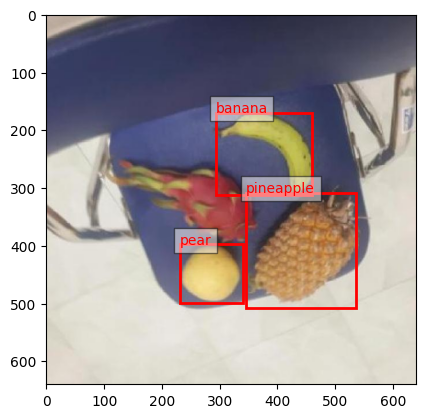

{5109: {'box': array([346, 308, 536, 508], dtype=object), 'label': 'pineapple'}, 5110: {'box': array([231, 397, 340, 498], dtype=object), 'label': 'pear'}, 5111: {'box': array([293, 169, 460, 312], dtype=object), 'label': 'banana'}}
{5109: {'box': array([131, 117, 204, 193]), 'label': 'pineapple'}, 5110: {'box': array([ 88, 151, 129, 189]), 'label': 'pear'}, 5111: {'box': array([111,  64, 175, 118]), 'label': 'banana'}}


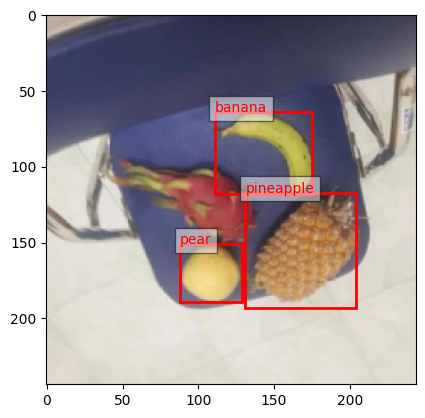

In [13]:
# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(first_plt_img, first_boxes, input_size, input_size)

# Print the resized boxes
print(first_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

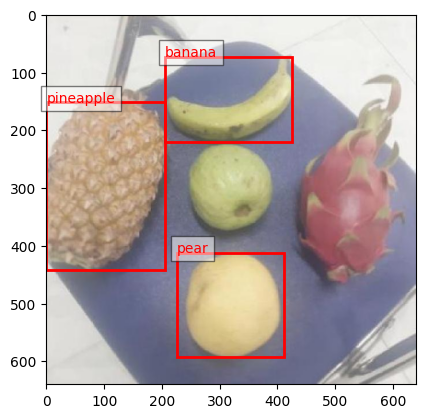

{3644: {'box': array([0, 151, 205, 441], dtype=object), 'label': 'pineapple'}, 3645: {'box': array([205, 72, 425, 220], dtype=object), 'label': 'banana'}, 3646: {'box': array([226, 412, 412, 593], dtype=object), 'label': 'pear'}}
{3644: {'box': array([  0,  57,  78, 168]), 'label': 'pineapple'}, 3645: {'box': array([ 78,  27, 162,  83]), 'label': 'banana'}, 3646: {'box': array([ 86, 157, 157, 226]), 'label': 'pear'}}


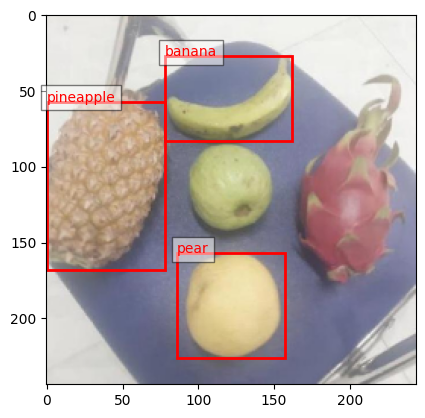

In [14]:
# Another random example
x = random.randint(0, len(train_image_files))

# Image file is at index x
random_image_path = train_image_files[x]
random_filename = os.path.basename(random_image_path)
random_plt_img = plt.imread(random_image_path)
random_boxes = get_boxes_for_image(random_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(random_plt_img, random_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(random_plt_img, random_boxes, input_size, input_size)

# Print the resized boxes
print(random_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

This seems to work, great! Let's make sure we have tensorflow installed

In [15]:
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

import tensorflow as tf
print(tf.__version__)

2.17.1


## Data preparation

This is where the magic happens - we prepare the data for our model specifically for our model. We resize each image with boxes and prepare the tensors for further use.

In [16]:
# Test function: Check for filenames without a label banana

# # Iterate through the annotations and find filenames without 'banana' label
# filenames_without_banana = []
# for filename in set(train_annotations['filename']):
#     boxes = get_boxes_for_image(filename, train_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana.append(filename)
#     else:
#       filenames_without_banana.append(filename)

# print(f"Filenames without 'banana' label in training set: {filenames_without_banana}")

# #Repeat for test and validation sets
# filenames_without_banana_test = []
# for filename in set(test_annotations['filename']):
#     boxes = get_boxes_for_image(filename, test_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_test.append(filename)
#     else:
#       filenames_without_banana_test.append(filename)

# print(f"Filenames without 'banana' label in test set: {filenames_without_banana_test}")

# filenames_without_banana_validation = []
# for filename in set(validation_annotations['filename']):
#     boxes = get_boxes_for_image(filename, validation_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_validation.append(filename)
#     else:
#       filenames_without_banana_validation.append(filename)

# print(f"Filenames without 'banana' label in validation set: {filenames_without_banana_validation}")

### Preparation for our model

We iterate and prepare each image. We resize and append one banana box or a dummy box for pictures without a banana to correspond with our model.

As pointed out by the many debug print statements, this part was tricky!

In [17]:
def data_load(image_files, annotations):
    X = []
    Y = []

    for image_file in image_files:
        img = cv.imread(os.path.join(image_file), cv.IMREAD_GRAYSCALE)
        boxes = get_boxes_for_image(os.path.basename(image_file), annotations)

        # resize everything
        img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)

        # Check if a banana box exists
        banana_box_found = False
        for box_data in boxes.values():
            if box_data['label'] == 'banana':
                banana_box_found = True
                label = 1
                box = np.array(box_data['box'], dtype=float)
                break  # Stop searching after finding the first banana box

        # Handle images with no banana box
        if not banana_box_found:
            label = 0  # Set label to 0 for "no banana"
            box = np.array([0, 0, 0, 0], dtype=float)  # Create a dummy bounding box

        # resize_img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)
        # print(boxes)
        # return
        img = img.astype(float) / 255.
        # print(img)
        # print(box)
        # we already have a float array
        box = np.asarray(box, dtype=float)
        # we wait with normalizing the bounding boxes
        # box = box / input_size
        # print(box)
        # box = np.append(box, label)
        label = np.append(box, label)
        # print(label)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    # we expand for the batch dimension
    X = np.expand_dims(X, axis=3)
    Y = np.array(Y)
    # print(X)
    # print(Y)

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

Because this part can take a lot of time, depending on the connection from colab to Google Drive, we can recreate or reload here.

In [18]:
if recreate_dataset:
  print('recreating ds')
  raw_train_ds = data_load(train_image_files, train_annotations)
  raw_validation_ds = data_load(validation_image_files, validation_annotations)
  raw_test_ds = data_load(test_image_files, test_annotations)
else:
  # load from drive
  print('loading from drive')
  raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_one_banana_only_saved')
  raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_one_banana_only_saved')
  raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_one_banana_only_saved')

  # raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
  # raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
  # raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

loading from drive


In [19]:
!pwd

/content/drive/MyDrive/assignment-computer-vision


In [20]:
# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved_long_run')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved_long_run')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved_long_run')

We need to hot encode the labels. We could also use the label directly, since we have a binary classification.

In [21]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

We define the batch size and tune the datasets for our pipeline

In [22]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [23]:
train_ds = tune_training_ds(raw_train_ds)

In [24]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_image_files) // 4)
    # dataset = dataset.repeat()
    return dataset

In [25]:
validation_ds = tune_validation_ds(raw_validation_ds)

In [26]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(test_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [27]:
test_ds = tune_test_ds(raw_test_ds)

### Dataset ispection

Ensure we have the dataset correct: Inspect the first image from the training_ds with boxes

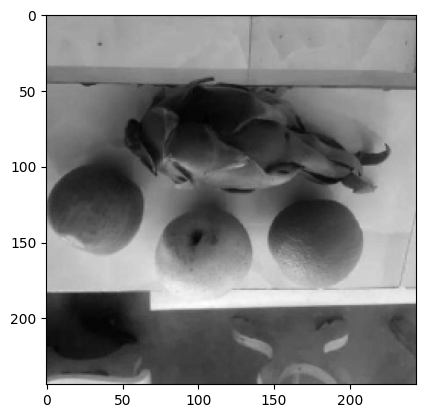

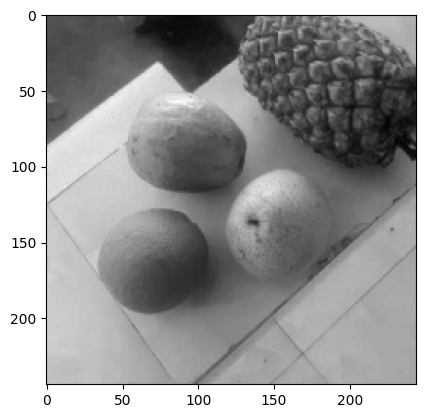

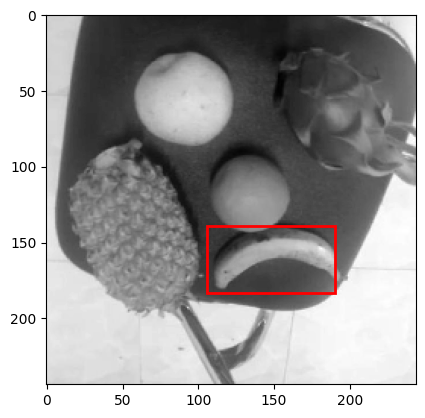

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for image, (label, box) in train_ds.take(3):
    # Convert the image to a NumPy array and remove the batch dimension
    image = image.numpy()[0, :, :]  # Assuming grayscale image and removing channel dim

    # print(label, box)

    # Accessing the bounding box coordinates and label
    xmin = box[0][0].numpy()
    ymin = box[0][1].numpy()
    xmax = box[0][2].numpy()
    ymax = box[0][3].numpy()
    # print(xmin, ymin, xmax, ymax)
    label = label[0].numpy()
    # print(label)


    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display grayscale image

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display the plot
    plt.show()

## Building the model

We are building a simple object detector, our model has two heads: one to classify the object type (or label or class) and another head to output the object bounding box.

Addendum: I think this is where we take a wrong turn. I don't think it's possible to train this model for our purpose. More on this below.
We tried improving by introducing optimized Learning Rate (ReduceLROnPlateau), Dropout and L2 Regularization, Different optimizers Adam <-> SGD, but without much improvement.

In [29]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01), # L2 regularization
                              input_shape=(input_size, input_size, 1))(inputs)

    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu'
  , kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='sigmoid', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units=4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    #           loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
    #           metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    model.compile(optimizer=tf.keras.optimizers.Adam(),
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [30]:
model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 244, 244, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 242, 242, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 242, 242, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 121, 121, 16)   │              0 │ dropout[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 119, 119, 32)   │          4,640 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 119, 119, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 59, 59, 32)     │              0 │ dropout_1[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 57, 57, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 28, 28, 64)     │              0 │ dropout_2[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50176)          │              0 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │      3,211,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_head (Dense)   │ (None, 2)              │            130 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor_head (Dense)    │ (None, 4)              │            260 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

We keep the model small for now:

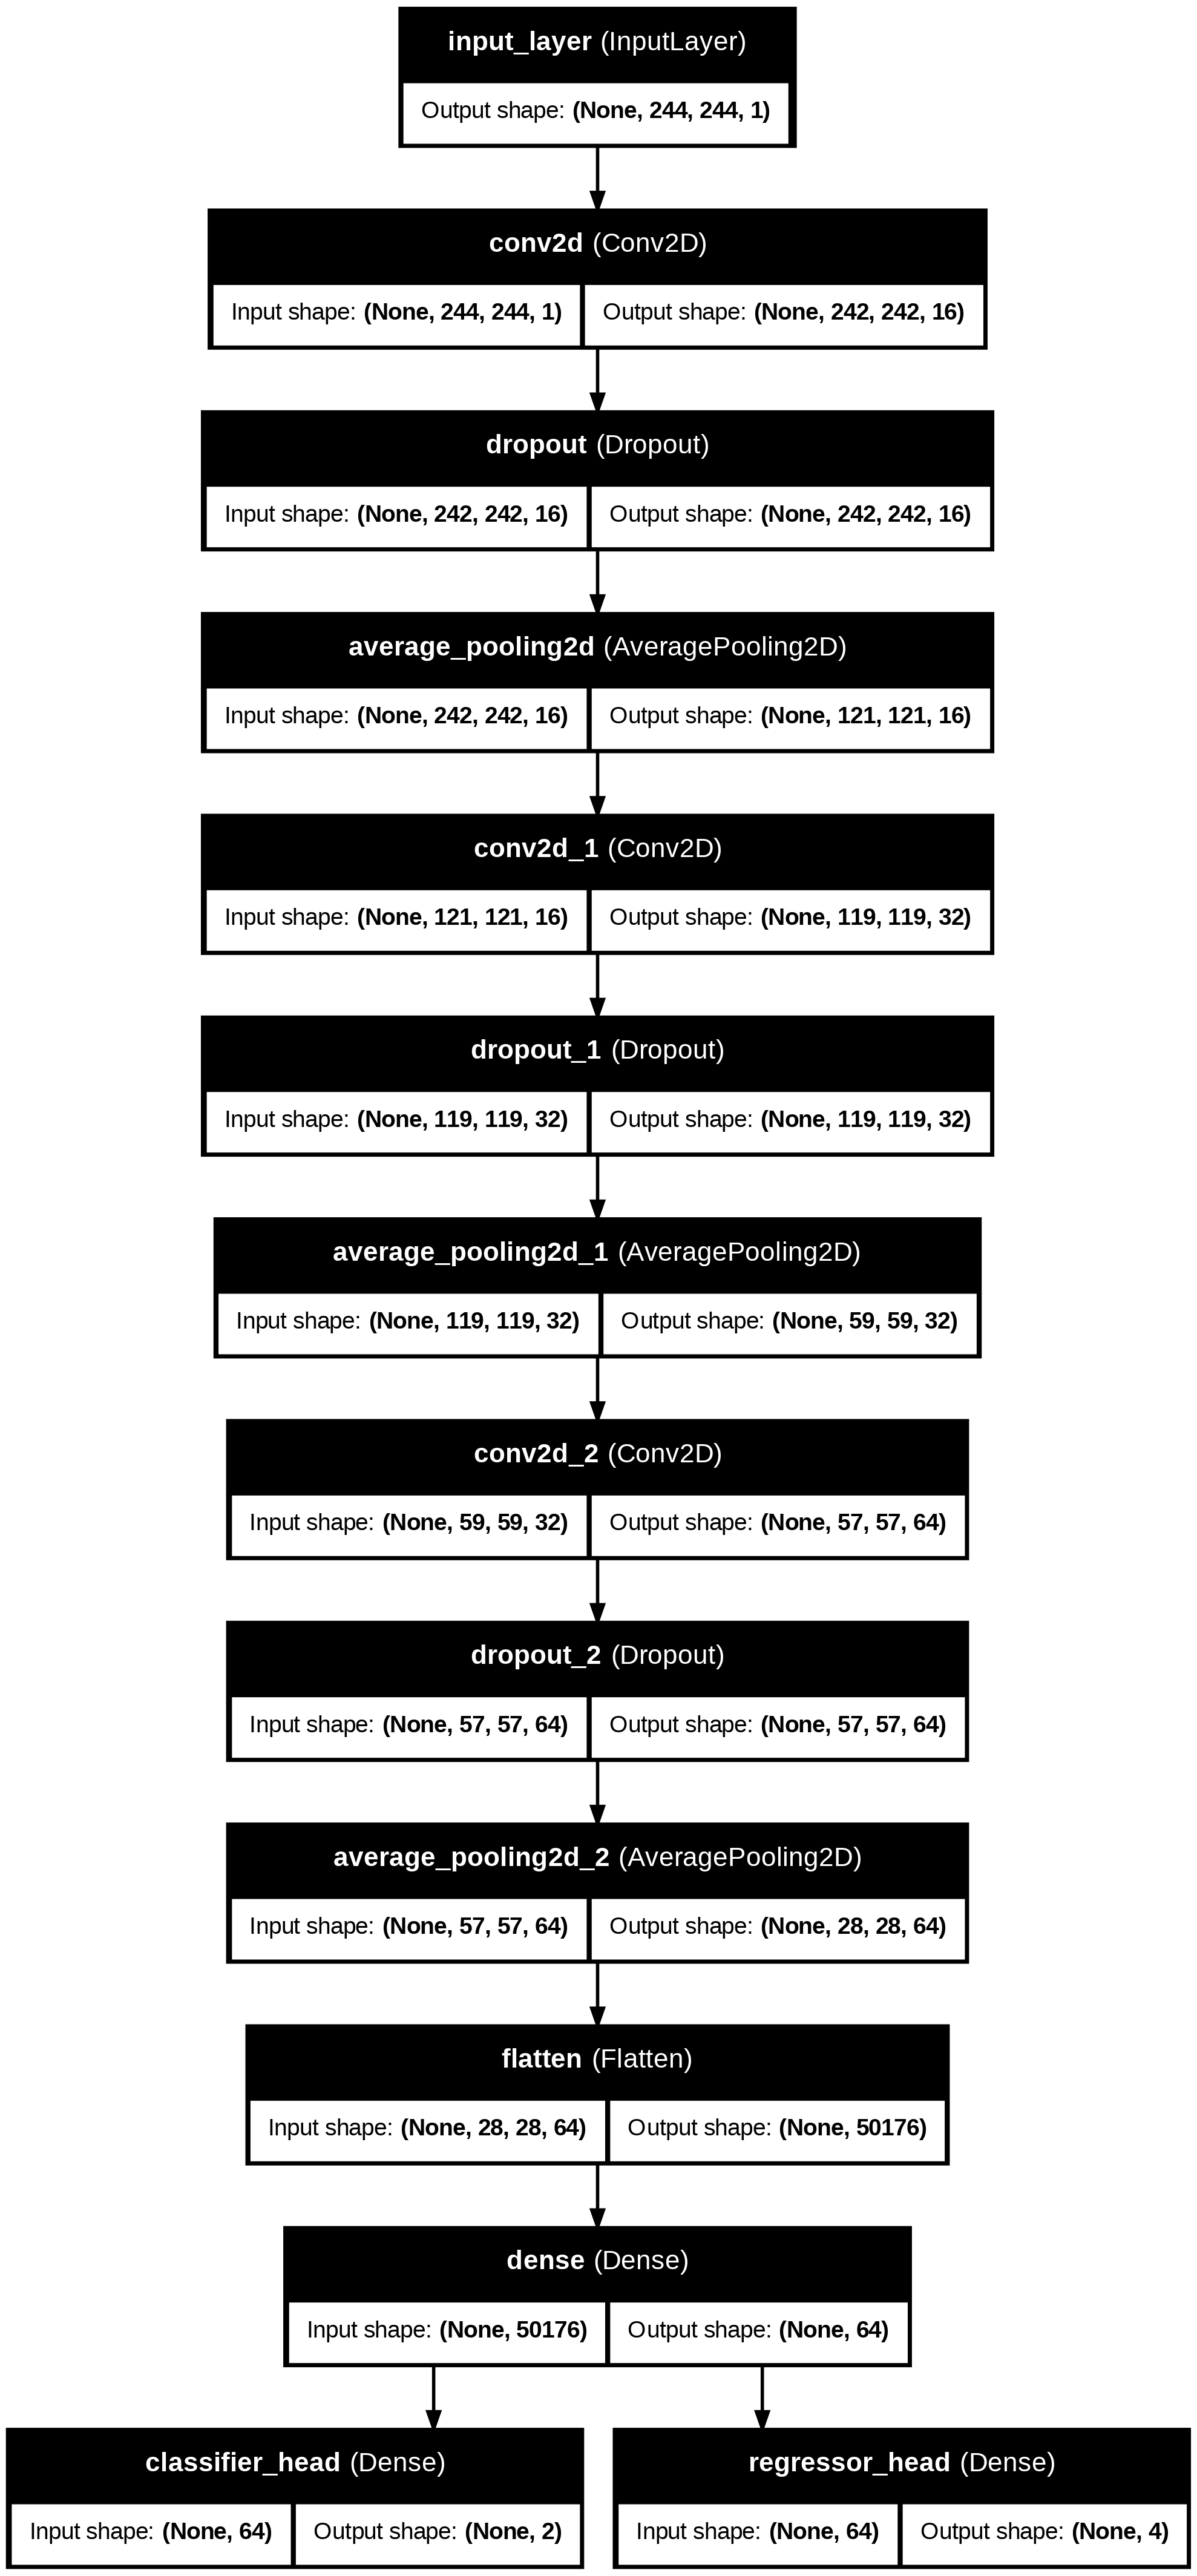

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

We also tried Max Pooling

## Training

We train for 1000 epochs with early stopping for Validation Loss and a lot of patience.

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 1000

model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True) # Add EarlyStopping callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(train_ds,
                    steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
                    validation_data=validation_ds,
                    epochs=EPOCHS,
                    callbacks=([early_stopping], [reduce_lr]) # Pass callbacks to model.fit
                    )

Epoch 1/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - classifier_head_accuracy: 0.7778 - classifier_head_loss: 2.1058 - loss: 6848.8179 - regressor_head_loss: 6844.2593 - regressor_head_mse: 6844.2593 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 1.6454 - val_loss: 7439.2310 - val_regressor_head_loss: 7505.6602 - val_regressor_head_mse: 7434.8945 - learning_rate: 0.0010
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - classifier_head_accuracy: 0.7907 - classifier_head_loss: 0.6551 - loss: 4528.9844 - regressor_head_loss: 4525.6133 - regressor_head_mse: 4525.6133 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 1.4713 - val_loss: 5758.8862 - val_regressor_head_loss: 5788.1387 - val_regressor_head_mse: 5754.6089 - learning_rate: 0.0010
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - classifier_head_accuracy: 0.7815 - classifier_head_loss: 0.6003 - loss: 4348.9478 - regressor_head_loss: 4345.4482 - regressor_head_mse: 4345.4482 - val_c

## Evaluation

Let's evaluate the last training run

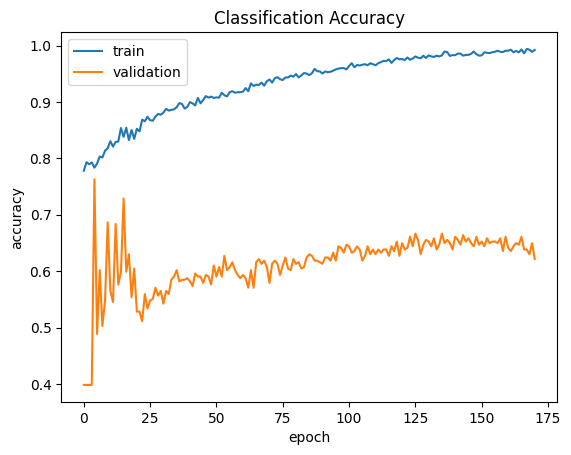

In [33]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

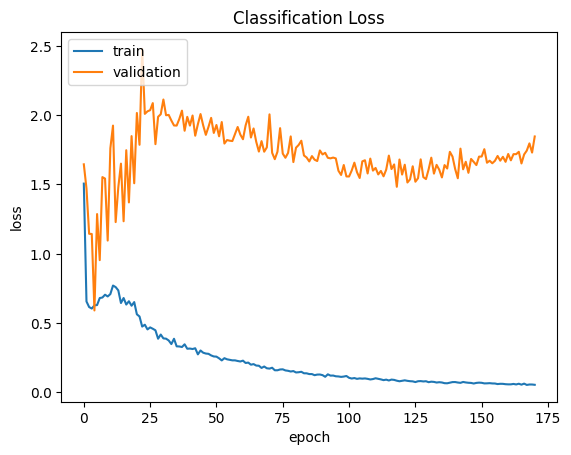

In [34]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

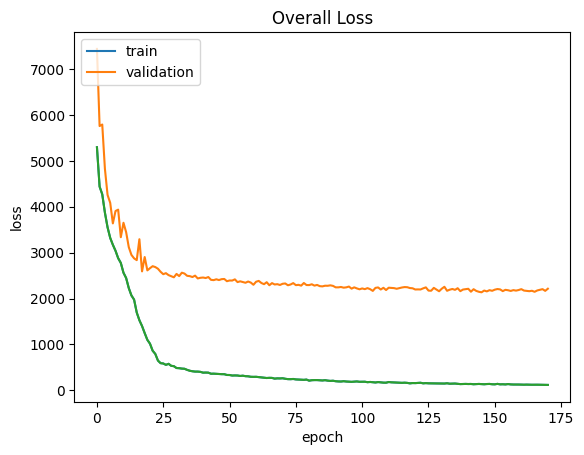

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Overall Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

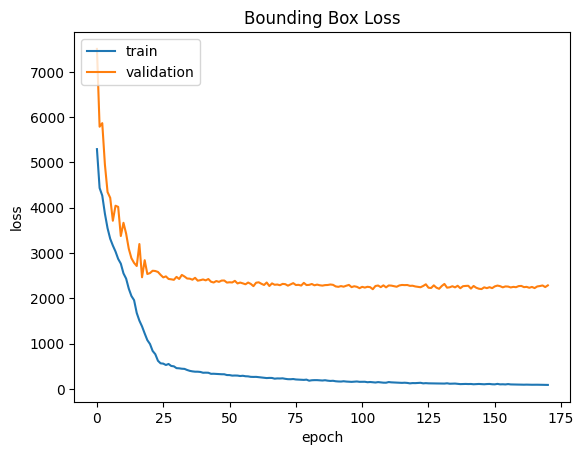

In [36]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

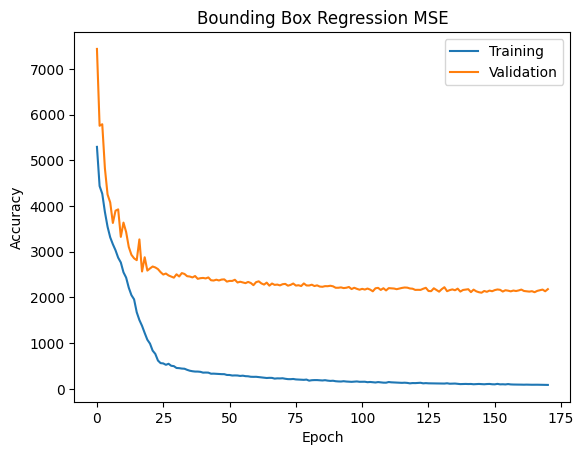

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['regressor_head_mse'])
plt.plot(history.history['val_regressor_head_mse'])
plt.title('Bounding Box Regression MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Analysis: I believe that the classification head overfits right away and prevents the regressor head to train after that.

One way to solve this would be to freeze the classification head and only train the regressor head from this point on. Unfortunately time was running out on this assignment and I coud not implement this strategy. I am looking forward to try this out next year since it's a very interesting challenge.

## Predictions

We predict a few examples using IoU

In [38]:
# IoU evaluation

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A NumPy array representing the first bounding box [xmin, ymin, xmax, ymax].
        box2: A NumPy array representing the second bounding box [xmin, ymin, xmax, ymax].

    Returns:
        The IoU value (a float between 0 and 1).
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
(244, 244, 1)
Image 0: True Label: 1 Pred Label: 0, True box [117. 141. 173. 181.] Pred box [51.287453 45.45499  39.851612 55.043636]
Image 0: IoU: 0.0


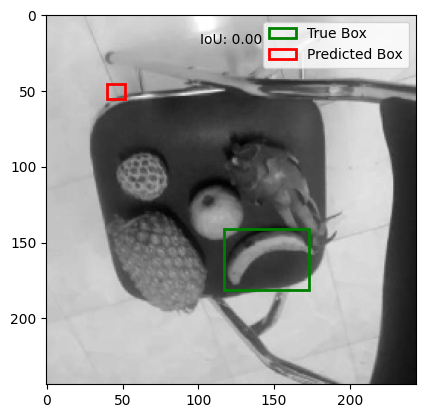

(244, 244, 1)
Image 1: True Label: 1 Pred Label: 1, True box [ 83.  35. 167.  81.] Pred box [ 69.23378  90.0743  155.09106 157.06998]
Image 1: IoU: 0.0


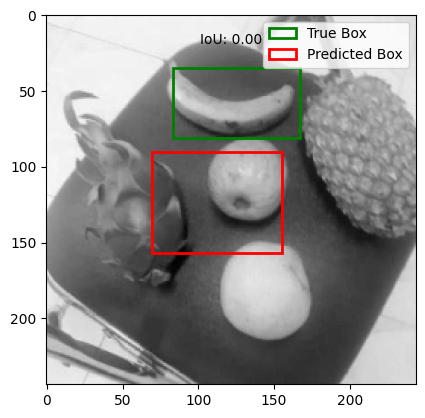

(244, 244, 1)
Image 2: True Label: 1 Pred Label: 1, True box [ 38. 141.  91. 222.] Pred box [ 50.723152 144.53201  111.800385 227.5372  ]
Image 2: IoU: 0.4998215453957539


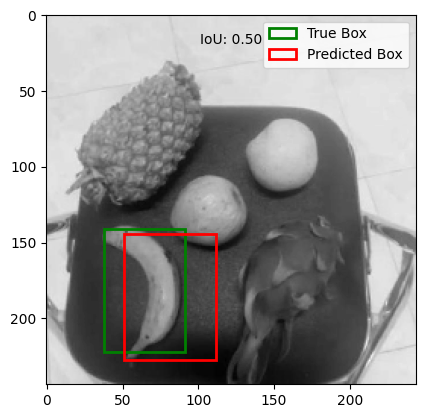

(244, 244, 1)
Image 3: True Label: 1 Pred Label: 1, True box [ 73.  91. 117. 138.] Pred box [ 73.409996  58.362206 115.61507  112.64534 ]
Image 3: IoU: 0.2651424377836455


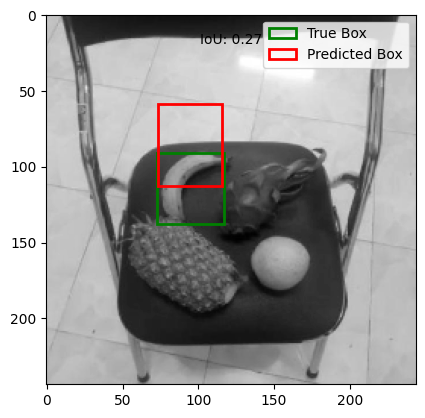

(244, 244, 1)
Image 4: True Label: 1 Pred Label: 0, True box [112.  44. 205.  94.] Pred box [ 63.0543      3.7136972 113.759094   41.652065 ]
Image 4: IoU: 0.0


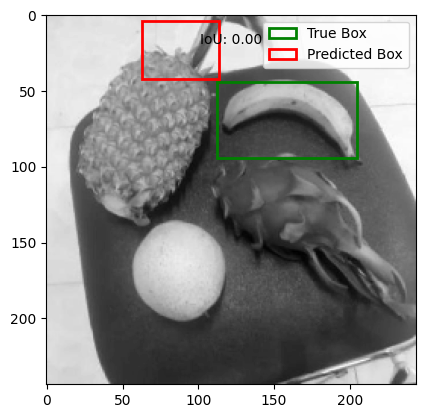

(244, 244, 1)
Image 5: True Label: 0 Pred Label: 1, True box [0. 0. 0. 0.] Pred box [17.184011  5.076968 23.705156 12.480071]
Image 5: IoU: 0.0


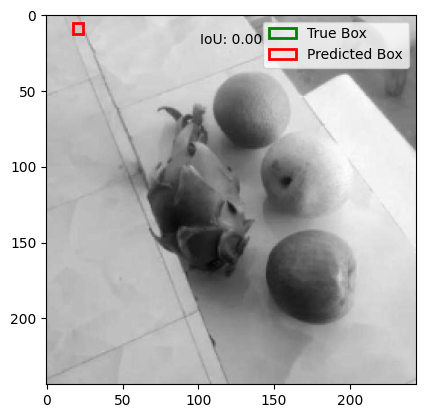

(244, 244, 1)
Image 6: True Label: 1 Pred Label: 1, True box [ 27. 136.  80. 221.] Pred box [ 52.011055 165.42027  120.63945  280.70386 ]
Image 6: IoU: 0.14322827127609836


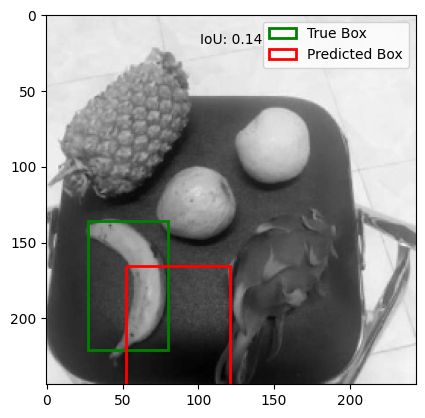

(244, 244, 1)
Image 7: True Label: 0 Pred Label: 1, True box [0. 0. 0. 0.] Pred box [ 73.85585   23.500702 103.10002   44.002594]
Image 7: IoU: 0.0


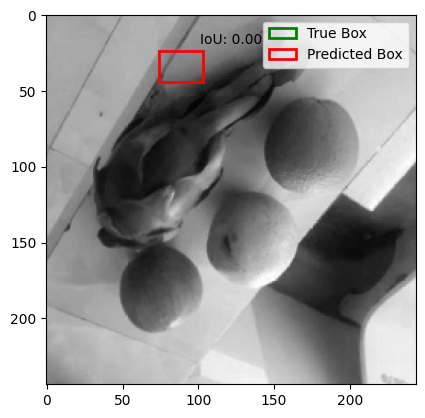

(244, 244, 1)
Image 8: True Label: 1 Pred Label: 1, True box [  8.  67.  55. 139.] Pred box [ 17.949455  49.981445  78.16901  120.183014]
Image 8: IoU: 0.34930740123770165


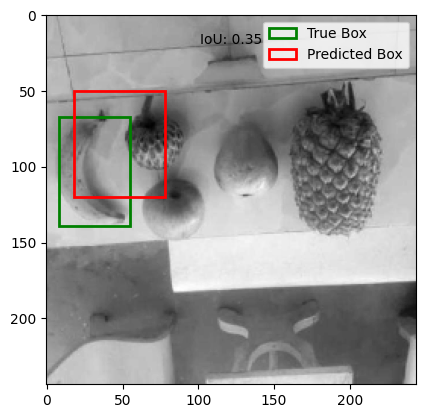

(244, 244, 1)
Image 9: True Label: 1 Pred Label: 1, True box [120.  22. 198. 100.] Pred box [ 70.90953   53.612854 165.832    108.54078 ]
Image 9: IoU: 0.23179717555486562


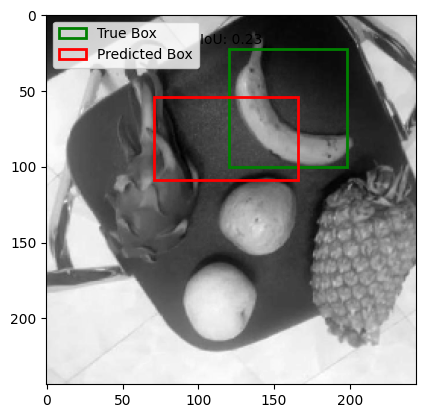

In [39]:
# Predict some examples from the test set

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

for image, (label, box) in test_ds.take(1):  # Get the first batch
    # print(len(image))
    # Get predictions
    predictions = model.predict(image)

    # Assuming 'predictions' is a tuple with classification and bounding box
    predicted_labels = predictions[0]
    predicted_boxes = predictions[1]


    for i in range(10): # predict 10 images from the batch
        # Convert image to NumPy array
        print(image[i].numpy().shape)
        img = image[i].numpy()[:, :, 0]

        # Get true values
        true_label = label[i].numpy().argmax()
        true_box = box[i].numpy()

        # Get predicted values
        pred_label = predicted_labels[i].argmax()
        pred_box = predicted_boxes[i]
        print(f"Image {i}: True Label: {true_label} Pred Label: {pred_label}, True box {true_box} Pred box {pred_box}")

        # Create plot
        fig, ax = plt.subplots(1)
        ax.imshow(img, cmap='gray')

        # Add true bounding box
        rect_true = patches.Rectangle((true_box[0], true_box[1]), (true_box[2]-true_box[0]), (true_box[3]-true_box[1]), linewidth=2, edgecolor='g', facecolor='none', label='True Box')
        ax.add_patch(rect_true)

        # Add predicted bounding box
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), (pred_box[2]-pred_box[0]), (pred_box[3]-pred_box[1]), linewidth=2, edgecolor='r', facecolor='none', label='Predicted Box')
        ax.add_patch(rect_pred)

        ax.legend()

        # Calculate IoU
        iou = calculate_iou(true_box, pred_box)
        print(f"Image {i}: IoU: {iou}")

        # Add IoU to the plot (optional)
        plt.text(0.5, 0.95, f"IoU: {iou:.2f}", ha='center', va='top', transform=ax.transAxes)  # Position the text

        # Display the plot
        plt.show()

## Conclusion

This model cannot solve our problem, but gave us countless insights into resizing boxes, displaying our images with correspoinding boxes (before and after resizing), bringing them into the right format for further consumption by our model and different strategies for optimizing the model. Unfortunately to no avail with this architecture.

My takeaway is, that an approach from scratch takes more time than expected but gives a lot of insight about what happens under the hood of established frameworks. If I would have had more time, I would start by redefining the architecture of the model and finding a better solution in this regard.

We will now move on to such an established and more suitable model, YOLOv5.

# Fruit Detection with YOLOv5

My next step is to use YOLOv5 for the same task.

The goal is to improve for the task of object detection with the same dataset of fruits on a platter.

I set up the corresponding data (images and YOLOv5 formated labels) in Google Drive.

## Setting up the YOLOv5 environment

### Connect to Google Drive

In [40]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Install and start comet

We use [Comet ML](https://www.comet.com/site/) to track learning, parameters, predictions.
There are other similar tools available, but Comet ML is very convincing.

Comet ML has to be initialized before importing torch or other frameworks.

In [41]:
!pwd

/content/drive/My Drive/assignment-computer-vision


In [42]:
%cd /content/drive/MyDrive/assignment-computer-vision/
# !ls -l

/content/drive/MyDrive/assignment-computer-vision


In [43]:
%pip install comet_ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.9/709.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.8/981.8 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.1 MB/s eta 0:00:00


### Initialize Comet

We have to initialize and import before any references to torch

In [44]:
import comet_ml

from comet_ml import start
from comet_ml.integration.pytorch import log_model

comet_ml.login()
experiment = start(
  project_name="fruit-detection-yolov5",
  workspace="miam-bonbon"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/miam-bonbon/fruit-detection-yolov5/780ede500fbe485e8940d0e5b9fdcb26



### Install ultralytics in our Colab environment:

In [45]:
!pip install torch torchvision torchaudio

COMET INFO: Couldn't find a Git repository in '/content/drive/MyDrive/assignment-computer-vision' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [46]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 17.7 MB/s eta 0:00:00


In [49]:
!nvidia-smi
# tf.config.list_physical_devices('GPU')

Fri Nov 29 19:23:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |   7757MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Setting up the data

We already have our data set up in the right folders on Google Drive

In [50]:
!ls datasets/data_yolov5 -l

total 18160
-rw------- 1 root root      347 Nov 26 16:28 data.yaml
-rw------- 1 root root      148 Nov 26 13:01 README.dataset.txt
-rw------- 1 root root      990 Nov 26 13:01 README.roboflow.txt
drwx------ 2 root root     4096 Nov 26 13:14 test
drwx------ 2 root root     4096 Nov 26 13:14 train
drwx------ 2 root root     4096 Nov 26 13:14 valid
-rw------- 1 root root 18581255 Nov 26 14:01 yolov5su.pt


In [51]:
# We copy the whole datasets folder to the local environment for faster processing

!cp -r /content/drive/MyDrive/assignment-computer-vision/datasets /content/datasets

In [52]:
%cd /content
!ls -l

/content
total 12
drwx------ 3 root root 4096 Nov 29 19:23 datasets
drwx------ 6 root root 4096 Nov 29 19:19 drive
drwxr-xr-x 1 root root 4096 Nov 25 19:13 sample_data


In [53]:
# Disconnect google drive just to be sure

from google.colab import drive
drive.flush_and_unmount()

In [54]:
!ls -l

total 8
drwx------ 3 root root 4096 Nov 29 19:23 datasets
drwxr-xr-x 1 root root 4096 Nov 25 19:13 sample_data


## Data Inspection

### Class Distribution

We want to get a feel for the distribution of the labels in the prepared train, val and test folders

In [55]:
import os

# set up our data paths
base_path = 'datasets/data_yolov5'
train_image_dir = os.path.join(base_path, 'train')
validation_image_dir = os.path.join(base_path, 'valid')
test_image_dir = os.path.join(base_path, 'test')
yaml_config = os.path.join(base_path, 'data.yaml')

Processed train with 2205 images
Processed valid with 448 images
Processed test with 212 images


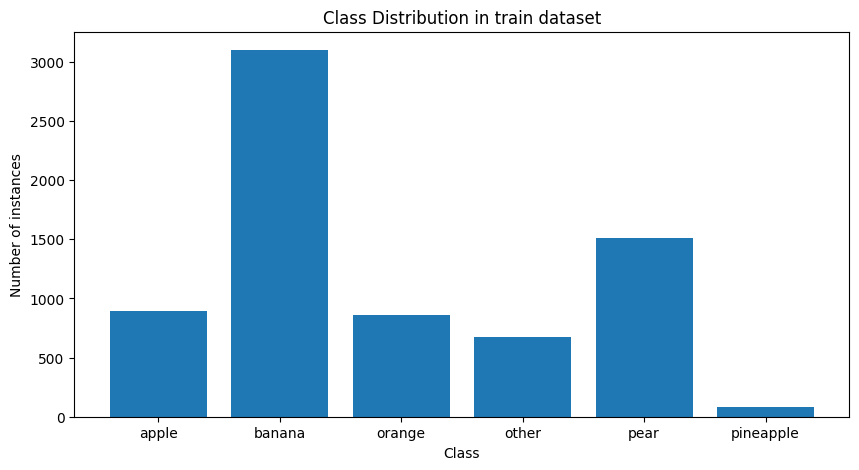

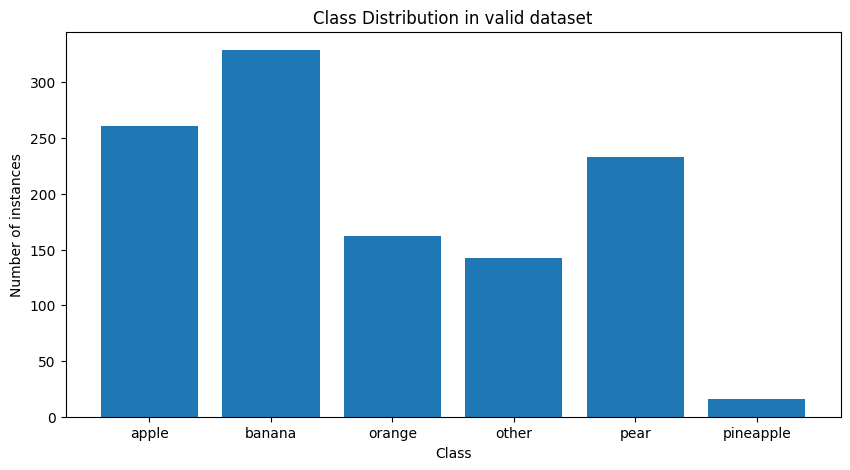

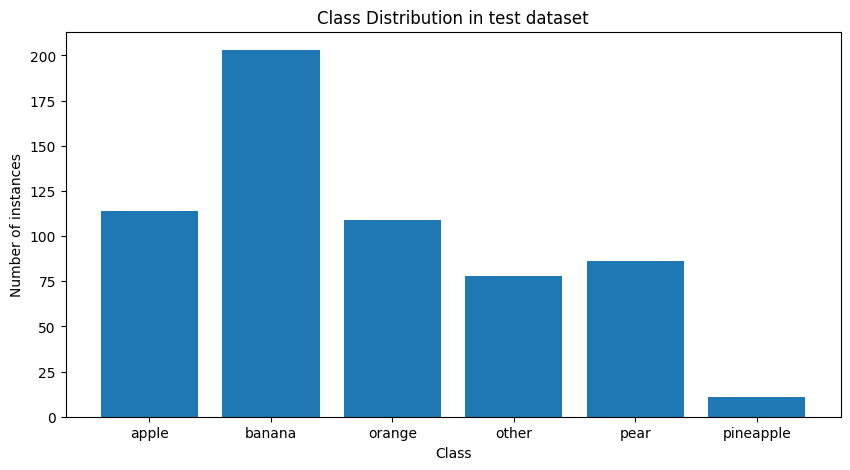

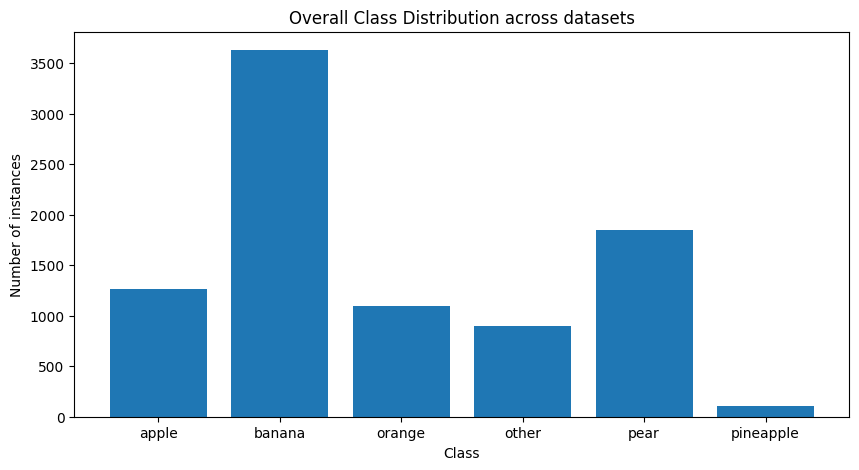

Total number of images: 2865


In [56]:
# Let's visualize data distribution over all datasets and for each dataset train validation and test

import os
import matplotlib.pyplot as plt
import pandas as pd

def visualize_data_distribution(base_path, classes=['apple', 'banana', 'orange', 'other', 'pear', 'pineapple']):
    """Visualizes the data distribution across datasets and splits."""
    splits = ["train", "valid", "test"]
    data = {}

    for split in splits:
        image_dir = os.path.join(base_path, split, 'images')
        # print(image_dir)
        label_dir = image_dir.replace('images', 'labels') #Assuming labels are in labels folder

        if os.path.exists(image_dir) and os.path.exists(label_dir):
          image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
          # print(image_files)
          num_images = len(image_files)

          class_counts = {}
          for label_file in [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]:
              with open(os.path.join(label_dir, label_file), 'r') as f:
                  for line in f:
                      class_id = int(line.split()[0])
                      class_counts[class_id] = class_counts.get(class_id, 0) + 1

          data[split] = {
              "num_images": num_images,
              "class_counts": class_counts
          }
          print(f"Processed {split} with {num_images} images")
        else:
          print(f"Warning: {split} folder not found")

    #Plotting the class distributions
    for split in data:
      plt.figure(figsize=(10, 5))
      plt.bar(classes, data[split]['class_counts'].values())
      # plt.bar(data[split]['class_counts'].keys(), data[split]['class_counts'].values())
      plt.xlabel("Class")
      plt.ylabel("Number of instances")
      plt.title(f"Class Distribution in {split} dataset")
      plt.show()

    # Generate overall dataset summary
    overall_class_counts = {}
    total_images = 0
    for split in data:
      total_images += data[split]["num_images"]
      for class_id, count in data[split]["class_counts"].items():
          overall_class_counts[class_id] = overall_class_counts.get(class_id, 0) + count

    plt.figure(figsize=(10, 5))
    plt.bar(classes, overall_class_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Number of instances")
    plt.title(f"Overall Class Distribution across datasets")
    plt.show()

    print(f"Total number of images: {total_images}")

visualize_data_distribution(base_path)

Overall distribution is not ideal - we should consider balancing later, even though YOLOv5 does this in the first place out of the box.

## Training

We have everything set up and can begin training

In [57]:
from ultralytics import YOLO

# let's evaluate with 5s
# model = YOLO('yolov5s.pt')
# and with 5m
model = YOLO('yolov5m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 48.2M/48.2M [00:00<00:00, 146MB/s]


In [58]:
# Check for config file
import os

config_file_path = yaml_config

if os.path.exists(config_file_path):
    print("config.yaml found at:", config_file_path)
else:
    print("config.yaml not found at:", config_file_path)

config.yaml found at: datasets/data_yolov5/data.yaml


In [59]:
# Train the model with Comet integration
results = model.train(
    data=yaml_config,
    batch=16,
    epochs=100,
    patience=10,
    device='cuda',
    cache=True,
    project='fruit-detection-yolov5',  # Comet project name
    name='fruit-detection-5m',  # Comet experiment name
    # verbose=True,
)

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=datasets/data_yolov5/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=fruit-detection-yolov5, name=fruit-detection-5m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.6MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/data_yolov5/train/labels... 2205 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:02<00:00, 1096.77it/s]

train: New cache created: /content/datasets/data_yolov5/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.5GB RAM): 100%|██████████| 2205/2205 [00:00<00:00, 2533.85it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/data_yolov5/valid/labels... 448 images, 0 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 915.04it/s]

val: New cache created: /content/datasets/data_yolov5/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 448/448 [00:00<00:00, 1227.41it/s]


Plotting labels to fruit-detection-yolov5/fruit-detection-5m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to fruit-detection-yolov5/fruit-detection-5m
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.03G     0.7627      1.102      1.107         75        640: 100%|██████████| 138/138 [00:21<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


                   all        448       1132      0.792      0.721      0.765      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.07G     0.7205     0.6964      1.082         67        640: 100%|██████████| 138/138 [00:18<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


                   all        448       1132      0.943      0.744      0.801      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.98G     0.7157     0.6593      1.081         67        640: 100%|██████████| 138/138 [00:18<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.00it/s]

                   all        448       1132      0.878      0.769      0.766      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.07G     0.6936     0.6104      1.071         89        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        448       1132      0.961      0.806       0.81      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.04G     0.6676     0.5755      1.053         72        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.80it/s]

                   all        448       1132      0.888      0.661      0.726       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.07G     0.6419     0.5431       1.04         56        640: 100%|██████████| 138/138 [00:18<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

                   all        448       1132      0.913      0.745      0.796       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.05G     0.6262     0.5091      1.031         57        640: 100%|██████████| 138/138 [00:18<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        448       1132      0.955      0.813       0.82      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.07G     0.6137     0.4977      1.027         59        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]

                   all        448       1132      0.943       0.79      0.818      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.06G     0.5922     0.4725      1.014         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        448       1132      0.959        0.8       0.82      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.09G     0.5872     0.4704      1.018         55        640: 100%|██████████| 138/138 [00:17<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.96it/s]

                   all        448       1132       0.91      0.776      0.795       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.07G     0.5736     0.4545       1.01         81        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.78it/s]

                   all        448       1132       0.96      0.799      0.819      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.08G     0.5636      0.437      1.004         59        640: 100%|██████████| 138/138 [00:18<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


                   all        448       1132      0.946      0.807      0.815      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.05G     0.5481     0.4177     0.9933         94        640: 100%|██████████| 138/138 [00:18<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.94it/s]

                   all        448       1132      0.961      0.761      0.811      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.07G     0.5347     0.4138     0.9881         78        640: 100%|██████████| 138/138 [00:18<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        448       1132       0.96      0.814      0.817        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.05G      0.539     0.4101     0.9859         75        640: 100%|██████████| 138/138 [00:18<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.94it/s]

                   all        448       1132      0.982       0.82       0.82      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.06G     0.5166     0.3933     0.9785         67        640: 100%|██████████| 138/138 [00:17<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        448       1132      0.967       0.82      0.822      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.05G     0.5083      0.388     0.9721         84        640: 100%|██████████| 138/138 [00:17<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]

                   all        448       1132      0.957      0.816      0.808      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.08G     0.5022     0.3804     0.9685         65        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]

                   all        448       1132       0.97      0.814      0.821      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.07G      0.504     0.3796     0.9743         85        640: 100%|██████████| 138/138 [00:18<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        448       1132      0.978      0.821       0.82      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.08G     0.4956     0.3749     0.9688         79        640: 100%|██████████| 138/138 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.04it/s]

                   all        448       1132      0.978      0.817      0.821      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.07G      0.489     0.3688      0.967         71        640: 100%|██████████| 138/138 [00:17<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.95it/s]

                   all        448       1132      0.973      0.815      0.822      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.07G     0.4886     0.3568     0.9628         87        640: 100%|██████████| 138/138 [00:18<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        448       1132      0.977      0.819      0.821      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.07G     0.4782      0.351     0.9597         62        640: 100%|██████████| 138/138 [00:17<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.86it/s]

                   all        448       1132      0.968      0.824      0.822      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.06G     0.4632     0.3428      0.949         79        640: 100%|██████████| 138/138 [00:17<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]

                   all        448       1132       0.95      0.809      0.817      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.07G     0.4674     0.3432     0.9558         65        640: 100%|██████████| 138/138 [00:18<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        448       1132      0.965      0.814      0.818      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.06G     0.4603     0.3412      0.956         69        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.03it/s]

                   all        448       1132      0.975      0.817      0.821      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.07G      0.453      0.326     0.9496         62        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.00it/s]

                   all        448       1132       0.98      0.825      0.822      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.07G     0.4487     0.3305     0.9458         89        640: 100%|██████████| 138/138 [00:18<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        448       1132      0.978      0.821       0.82      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.05G     0.4382     0.3259     0.9405         84        640: 100%|██████████| 138/138 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.88it/s]

                   all        448       1132      0.974       0.82      0.821       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.07G     0.4404     0.3174     0.9408         63        640: 100%|██████████| 138/138 [00:17<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        448       1132      0.976      0.823      0.821      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.06G     0.4301     0.3093     0.9338         71        640: 100%|██████████| 138/138 [00:18<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.05it/s]

                   all        448       1132       0.98       0.82      0.822      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.07G     0.4276     0.3054     0.9389         65        640: 100%|██████████| 138/138 [00:18<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.98it/s]

                   all        448       1132      0.979      0.822      0.819      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.06G      0.423     0.3064     0.9311         96        640: 100%|██████████| 138/138 [00:18<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.82it/s]

                   all        448       1132      0.979      0.826      0.821       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.07G     0.4226     0.3019     0.9321         66        640: 100%|██████████| 138/138 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.98it/s]

                   all        448       1132       0.96      0.821      0.813      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.06G     0.4206        0.3     0.9349         88        640: 100%|██████████| 138/138 [00:17<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]

                   all        448       1132      0.969      0.823      0.819      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.06G      0.415     0.2983     0.9334         62        640: 100%|██████████| 138/138 [00:18<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.05it/s]

                   all        448       1132      0.979      0.822      0.821      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.05G     0.4102     0.3002     0.9266         63        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.92it/s]

                   all        448       1132      0.979       0.82      0.819      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.04G     0.4008     0.2841      0.918         81        640: 100%|██████████| 138/138 [00:18<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.90it/s]

                   all        448       1132      0.977      0.823      0.819      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.06G     0.4019     0.2908     0.9277         96        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.01it/s]

                   all        448       1132      0.977      0.818      0.819      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.06G     0.4017      0.287     0.9262         42        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

                   all        448       1132      0.969      0.822      0.814      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.07G     0.3973     0.2811     0.9232         72        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.94it/s]

                   all        448       1132      0.971       0.82      0.821       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.06G     0.3826     0.2675     0.9153         89        640: 100%|██████████| 138/138 [00:18<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.10it/s]

                   all        448       1132       0.98      0.819      0.818      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.05G     0.3867      0.276     0.9189         78        640: 100%|██████████| 138/138 [00:17<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.94it/s]

                   all        448       1132      0.969      0.819      0.815      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.07G     0.3769       0.27     0.9132         71        640: 100%|██████████| 138/138 [00:18<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

                   all        448       1132      0.975      0.823      0.817      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.06G       0.38      0.266     0.9111         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]

                   all        448       1132       0.98      0.824      0.821      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.09G     0.3672     0.2609     0.9082         52        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.96it/s]


                   all        448       1132      0.978      0.821      0.823      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.07G     0.3705     0.2564     0.9087         73        640: 100%|██████████| 138/138 [00:17<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

                   all        448       1132      0.974      0.821      0.823      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.07G     0.3712     0.2569     0.9095         74        640: 100%|██████████| 138/138 [00:18<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]

                   all        448       1132      0.982      0.824      0.821      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.06G     0.3664      0.255      0.911         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.95it/s]

                   all        448       1132      0.971      0.822      0.818       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.07G     0.3744     0.2599     0.9156         74        640: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.03it/s]

                   all        448       1132      0.979       0.82      0.821      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.06G     0.3612     0.2508     0.9108         68        640: 100%|██████████| 138/138 [00:18<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        448       1132      0.977      0.824      0.821      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.07G     0.3526     0.2501     0.9051         68        640: 100%|██████████| 138/138 [00:18<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        448       1132      0.973      0.824      0.819      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.07G     0.3524      0.246     0.9003         75        640: 100%|██████████| 138/138 [00:17<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]

                   all        448       1132      0.969      0.823      0.813      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.08G     0.3438     0.2403     0.8946         81        640: 100%|██████████| 138/138 [00:17<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.95it/s]

                   all        448       1132      0.969      0.825      0.817      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.02G     0.3382     0.2392     0.8967         86        640: 100%|██████████| 138/138 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.99it/s]

                   all        448       1132      0.978      0.822      0.819      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.08G     0.3372     0.2368      0.899         64        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.99it/s]

                   all        448       1132      0.977      0.823      0.818      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.07G     0.3363     0.2352     0.8998         68        640: 100%|██████████| 138/138 [00:17<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.98it/s]

                   all        448       1132      0.978      0.825       0.82      0.728
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



57 epochs completed in 0.345 hours.
Optimizer stripped from fruit-detection-yolov5/fruit-detection-5m/weights/last.pt, 50.5MB
Optimizer stripped from fruit-detection-yolov5/fruit-detection-5m/weights/best.pt, 50.5MB

Validating fruit-detection-yolov5/fruit-detection-5m/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv5m summary (fused): 248 layers, 25,048,690 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]


                   all        448       1132      0.974      0.821      0.822      0.728
                 apple        205        233      0.989      0.983       0.98      0.881
                banana        235        329      0.976      0.992      0.982       0.82
                orange        162        162      0.974          1      0.978      0.879
                 other         11         16          1          0     0.0529     0.0421
                  pear        140        141       0.93      0.972      0.955      0.873
             pineapple        251        251      0.972      0.981      0.987      0.871
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to fruit-detection-yolov5/fruit-detection-5m


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : meaningful_duplex_5044
COMET INFO:     url                   : https://www.comet.com/miam-bonbon/fruit-detection-yolov5/780ede500fbe485e8940d0e5b9fdcb26
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [787]                 : (19895.615234375, 6529070.0)
COMET INFO:     lr/pg0 [115]               : (0.00033091787439613527, 0.0009778323671497586)
COMET INFO:     lr/pg1 [115]               : (0.00033091787439613527, 0.0009778323671497586)
COMET INFO:     lr/pg2 [115]               : (0.00033091787439613527, 0.000977832367

We observe, a lot of important parameters are automatically handled for us:

```
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=datasets/data_yolov5/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=fruit-detection-yolov5, name=fruit-detection-5m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=None, workspace=None, nms=False, lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, bgr=0.0, mosaic=1.0, mixup=0.0, copy_paste=0.0, copy_paste_mode=flip, auto_augment=randaugment, erasing=0.4, crop_fraction=1.0, cfg=None, tracker=botsort.yaml, save_dir=fruit-detection-yolov5/fruit-detection-5m
```
These are the default parameters for training.

`Downloading https://ultralytics.com/assets/Arial.ttf to '/root/.config/Ultralytics/Arial.ttf'...`

Even the font can be parameterised

`Overriding model.yaml nc=80 with nc=6`

we have 6 classes

```
                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384, 768, 3, 2]              
  8                  -1  2   4134912  ultralytics.nn.modules.block.C3              [768, 768, 2]                 
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  1    295680  ultralytics.nn.modules.conv.Conv             [768, 384, 1, 1]              
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   1182720  ultralytics.nn.modules.block.C3              [768, 384, 2, False]          
 14                  -1  1     74112  ultralytics.nn.modules.conv.Conv             [384, 192, 1, 1]              
 15                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 16             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 17                  -1  2    296448  ultralytics.nn.modules.block.C3              [384, 192, 2, False]          
 18                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 19            [-1, 14]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 20                  -1  2   1035264  ultralytics.nn.modules.block.C3              [384, 384, 2, False]          
 21                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 22            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 23                  -1  2   4134912  ultralytics.nn.modules.block.C3              [768, 768, 2, False]          
 24        [17, 20, 23]  1   4221538  ultralytics.nn.modules.head.Detect           [6, [192, 384, 768]]          
YOLOv5m summary: 339 layers, 25,068,610 parameters, 25,068,594 gradients, 64.4 GFLOPs
```

This is our model - 339 layers, quite a bit bigger than our last one!


`Transferred 553/559 items from pretrained weights`

We use transfer learning here

`TensorBoard: Start with 'tensorboard --logdir fruit-detection-yolov5/fruit-detection-5m', view at http://localhost:6006/`

We can ignore tensorboard, since we're using Comet ML

`Freezing layer 'model.24.dfl.conv.weight'`

Again, transfer learning

```
`AMP: running   checks...
Downloading https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt to 'yolo11n.pt'...
100%|██████████| 5.35M/5.35M [00:00<00:00, 312MB/s]
AMP: checks passed ✅`
```

Automatic mixed precision (AMP) allows users to easily enable automatic mixed precision training enabling higher performance and memory savings of up to 50% on Tensor Core GPUs

```
train: Scanning /content/datasets/data_yolov5/train/labels... 2205 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:01<00:00, 1159.82it/s]
train: New cache created: /content/datasets/data_yolov5/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
train: Caching images (2.5GB RAM): 100%|██████████| 2205/2205 [00:00<00:00, 2381.41it/s]
```

For deterministic results we could consider cache='disk'

```
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
```

We even have albumentation working for us out of the box!

```
val: Scanning /content/datasets/data_yolov5/valid/labels... 448 images, 0 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 907.78it/s]val: New cache created: /content/datasets/data_yolov5/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.5GB RAM): 100%|██████████| 448/448 [00:00<00:00, 1657.84it/s]
```

This is preparing the training part.


```
Plotting labels to fruit-detection-yolov5/fruit-detection-5m/labels.jpg...
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically...
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
```
We have auto optimizer

`TensorBoard: model graph visualization added ✅`

Again, TensorBoard can be ignored

```
Image sizes 640 train, 640 val
Using 8 dataloader workers
```

Image size and workers

### Commisioning to Comet ML

To commision to Comet ML we have to close when finished

In [61]:
# save to comet
experiment.end()

## Conclusion

I'm excited about the extensiveness of the YOLOv5 model and framework! The visualization with Comet ML is fantastic.

The results with default settings are amazing and surprizing. In hindsight, I wish I would have given up on the base model quicker and focus on "squeezing the juice" out of this model with all it's possibilities.